<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>

* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING X_raw](#2)    
* [3. DATA PIPELINE](#3) (Maleable section)
* [4. EXPLORATORY DATA ANALYSIS](#4)     
* [5. MODELING](#5)
* [6. EVALUATION](#6)
* [7. DISCUSSION](#7)  
* [8. DEPLOYMENT AND ENSEMBLES](#8)
* [9. END](#9)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from sklearn.cluster import AgglomerativeClustering

In [87]:
from lib.insight import *
from lib.utils_math import *
from lib.utils_pandas import *

In [14]:
# Parameters
path_root = "/home/magody/programming/python/data_science/"
path_output = f"{path_root}output/"

<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

## Description

<img src="https://github.com/KarnikaKapoor/Files/blob/main/Colorful%20Handwritten%20About%20Me%20Blank%20Education%20Presentation.png?raw=true">

## Load

In [29]:
#Loading the dataset
X_raw: pd.DataFrame = pd.read_csv(f"{path_root}data/customer_segmentation/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(X_raw))
# dataset_all = pd.concat([dataset_training, dataset_submission], axis=0, ignore_index=True)
dataset_all = X_raw.copy()
X_raw.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Eager explotarion

In [19]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

<a id="3"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PIPELINE</p>
- Special section: is used before and after by the following sections. Isn't in the common sequential flow.
- Maleable section.
- Here we define a pipeline for cleaning, preprocessing, dimensionality reduction, feature enginering, etc. That can be modified at any time for other following steps.
- Commonly, we use the insights got in EDA for write this part.

In [73]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

class PipelineModel:
    
    def __init__(self, columns_categories:dict, dimension_reduction_to=3) -> None:
        self.mask_importances = []
        self.columns_categories = columns_categories
        self.dimension_reduction_to = dimension_reduction_to;

    def processMissing(self, X_raw:pd.DataFrame, y=None):
        return X_raw.dropna(), y

    def processDuplicates(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def featureEngineering(self, X_raw:pd.DataFrame, y=None):

        # Transformation

        #Segmenting education levels in three groups
        X_raw["Education"]=X_raw["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

        # Creation

        X_raw["Dt_Customer"] = pd.to_datetime(X_raw["Dt_Customer"])
        dates = []
        for i in X_raw["Dt_Customer"]:
            i = i.date()
            dates.append(i)

        #Created a feature "Customer_For"
        days = []
        d1 = max(dates) #taking it to be the newest customer
        for i in dates:
            delta = d1 - i
            days.append(delta)

        X_raw["Customer_For"] = days
        X_raw["Customer_For"] = pd.to_numeric(X_raw["Customer_For"], errors="coerce")
        # X_raw.drop(["Dt_Customer"], axis=1,inplace=True)

        #Age of customer today 
        X_raw["Age"] = 2021-X_raw["Year_Birth"]
        # X_raw.drop(["Year_Birth"], axis=1,inplace=True)

        #Total spendings on various items
        X_raw["Spent"] = X_raw["MntWines"]+ X_raw["MntFruits"]+ X_raw["MntMeatProducts"]+ X_raw["MntFishProducts"]+ X_raw["MntSweetProducts"]+ X_raw["MntGoldProds"]
       

        #Deriving living situation by marital status"Alone"
        X_raw["Living_With"]=X_raw["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})
        # X_raw.drop(["Marital_Status"], axis=1,inplace=True)

        #Feature indicating total children living in the household
        X_raw["Children"]=X_raw["Kidhome"]+X_raw["Teenhome"]
        

        #Feature for total members in the householde
        X_raw["Family_Size"] = X_raw["Living_With"].replace({"Alone": 1, "Partner":2})+ X_raw["Children"]

        #Feature pertaining parenthood
        X_raw["Is_Parent"] = np.where(X_raw.Children > 0, 1, 0)

        
        # Renaming
        #For clarity
        X_raw=X_raw.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

        #Dropping some of the redundant features
        to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
        X_raw = X_raw.drop(to_drop, axis=1)

        # creating a subset of dataframe by dropping the features on deals accepted and promotions
        cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
        X_raw = X_raw.drop(cols_del, axis=1)

        return X_raw, y

    def processCategorical(self, X_raw:pd.DataFrame, y=None):
        #Get list of categorical variables
        object_cols = ['Education', 'Living_With']
        #Label Encoding the object dtypes.
        LE=LabelEncoder()
        for i in object_cols:
            X_raw[i]=X_raw[[i]].apply(LE.fit_transform)

        return X_raw, y

    def processOutliers(self, X_raw:pd.DataFrame, y=None):
        # outliers by setting a cap on Age and income. 
        X_raw = X_raw[(X_raw["Age"]<90)]
        X_raw = X_raw[(X_raw["Income"]<600000)]
        return X_raw, y

    def scaleData(self, X_raw:pd.DataFrame, y=None):
        
        #Scaling
        scaler = StandardScaler()
        scaler.fit(X_raw)
        X_raw = pd.DataFrame(scaler.transform(X_raw),columns= X_raw.columns)
        return X_raw, y


    def reduceDimension(self, X_raw:pd.DataFrame, y=None):
        # Usually PCA or feature importance with random forests

        #Initiating PCA to reduce dimentions aka features to 3
        pca = PCA(n_components=self.dimension_reduction_to)
        pca.fit(X_raw)

        columns = [f"col{i}" for i in range(1,self.dimension_reduction_to+1)]

        PCA_ds = pd.DataFrame(pca.transform(X_raw), columns=(columns))
        return PCA_ds, y
        
    def transform(self, X_raw:pd.DataFrame, y=None, is_training=True):
        
        X_clean = X_raw.copy()

        if y is not None:
            y_clean = y.copy()
        else:
            y_clean = None

        X_clean, y_clean = self.processMissing(X_clean, y_clean)
        X_clean, y_clean = self.processDuplicates(X_clean, y_clean)
        X_clean, y_clean = self.featureEngineering(X_clean, y_clean)
        X_clean, y_clean = self.processCategorical(X_clean, y_clean)
        X_clean, y_clean = self.processOutliers(X_clean, y_clean)
        X_clean, y_clean = self.scaleData(X_clean, y_clean)
        # X_clean, y_clean = self.reduceDimension(X_clean, y_clean)
        
        return X_clean, y_clean

# Temporal initialization
df_analisis = exploreSurface(dataset_all)
columns_categories = categorizeColumns(dataset_all, df_analisis)
pipeline = PipelineModel(columns_categories)

X_clean, _ = pipeline.transform(X_raw)
X_train, _ = pipeline.reduceDimension(X_clean)
print(X_train.head())
X_clean.head()

       col1      col2      col3
0  4.994347 -0.151104  2.647399
1 -2.884455 -0.006707 -1.863472
2  2.617864 -0.720810 -0.251823
3 -2.676036 -1.542050 -0.922613
4 -0.649591  0.209814 -0.020891


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


<a id="4"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EXPLORATORY DATA ANALYSIS</p>

In [57]:
X_EDA, _ = pipeline.transform(X_raw)  # this change at the same time pipeline change

## Exploration and understanding

In [33]:
df_analisis = exploreSurface(dataset_all)
df_analisis.to_csv(f"{path_output}analisis.csv", index=True)
df_analisis.head()

,type1,type2,porc_unique,problem,unique_values
ID,useless,unknown,1,"High variability, better drop this",[]
Year_Birth,numerical,discrete,0.0263393,,[]
Education,categorical,text,0.00223214,,"[2n Cycle, Basic, Graduation, Master, PhD]"
Marital_Status,categorical,text,0.00357143,,"[Absurd, Alone, Divorced, Married, Single, Tog..."
Income,numerical,discrete,0.890794,,[]


In [34]:
columns_categories = categorizeColumns(dataset_all, df_analisis)
print(columns_categories)

{'columns_numerical': ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], 'columns_categorical_numeric': ['Kidhome', 'Teenhome', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'], 'columns_categorical_text': ['Education', 'Marital_Status'], 'columns_mix': [], 'columns_drop': ['ID', 'Dt_Customer']}


In [26]:
# Missing and duplicates
miss_numerical, miss_categorical, posible_duplicates = getMissingAndDuplicates(dataset_all)
print("miss_numerical", miss_numerical)
print("miss_categorical", miss_categorical)
print("posible_duplicates", posible_duplicates)

miss_numerical [('Income', 0.010714285714285676)]
miss_categorical []
posible_duplicates [('Education', 0.9977678571428571), ('Marital_Status', 0.9964285714285714), ('Dt_Customer', 0.7040178571428571)]


## Visualization of data prepared for consumption

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

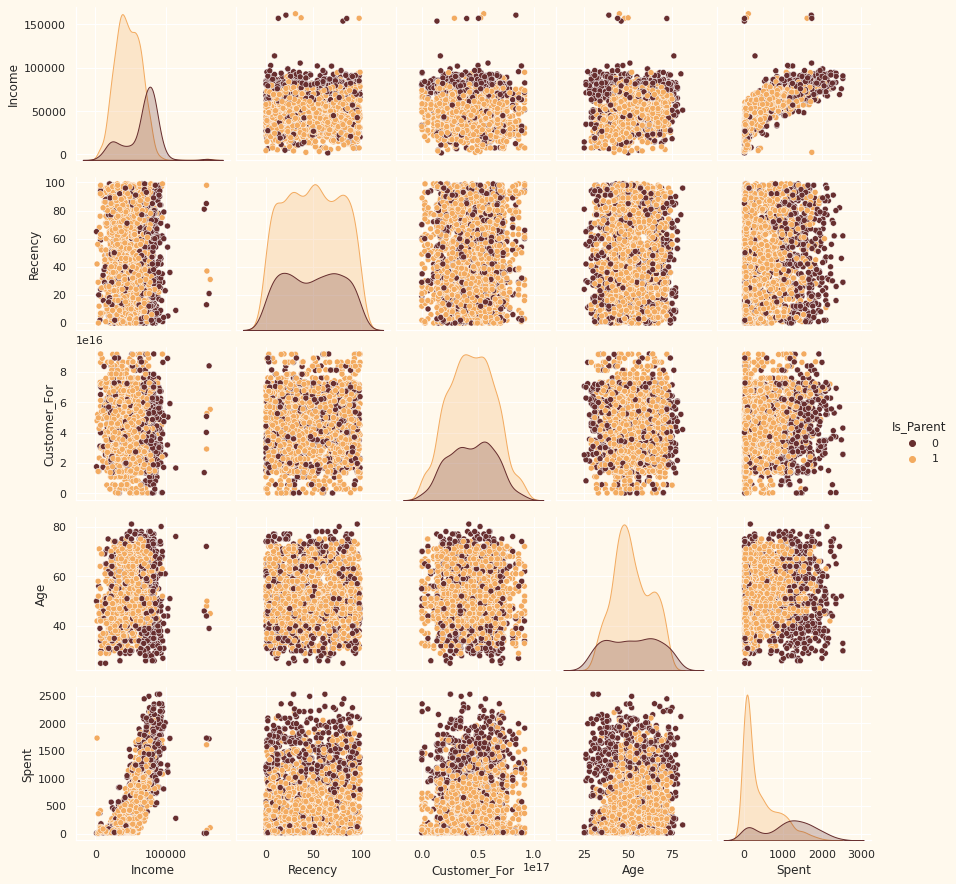

In [52]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(X_EDA[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

## Pivoting

## Correlation

<AxesSubplot:>

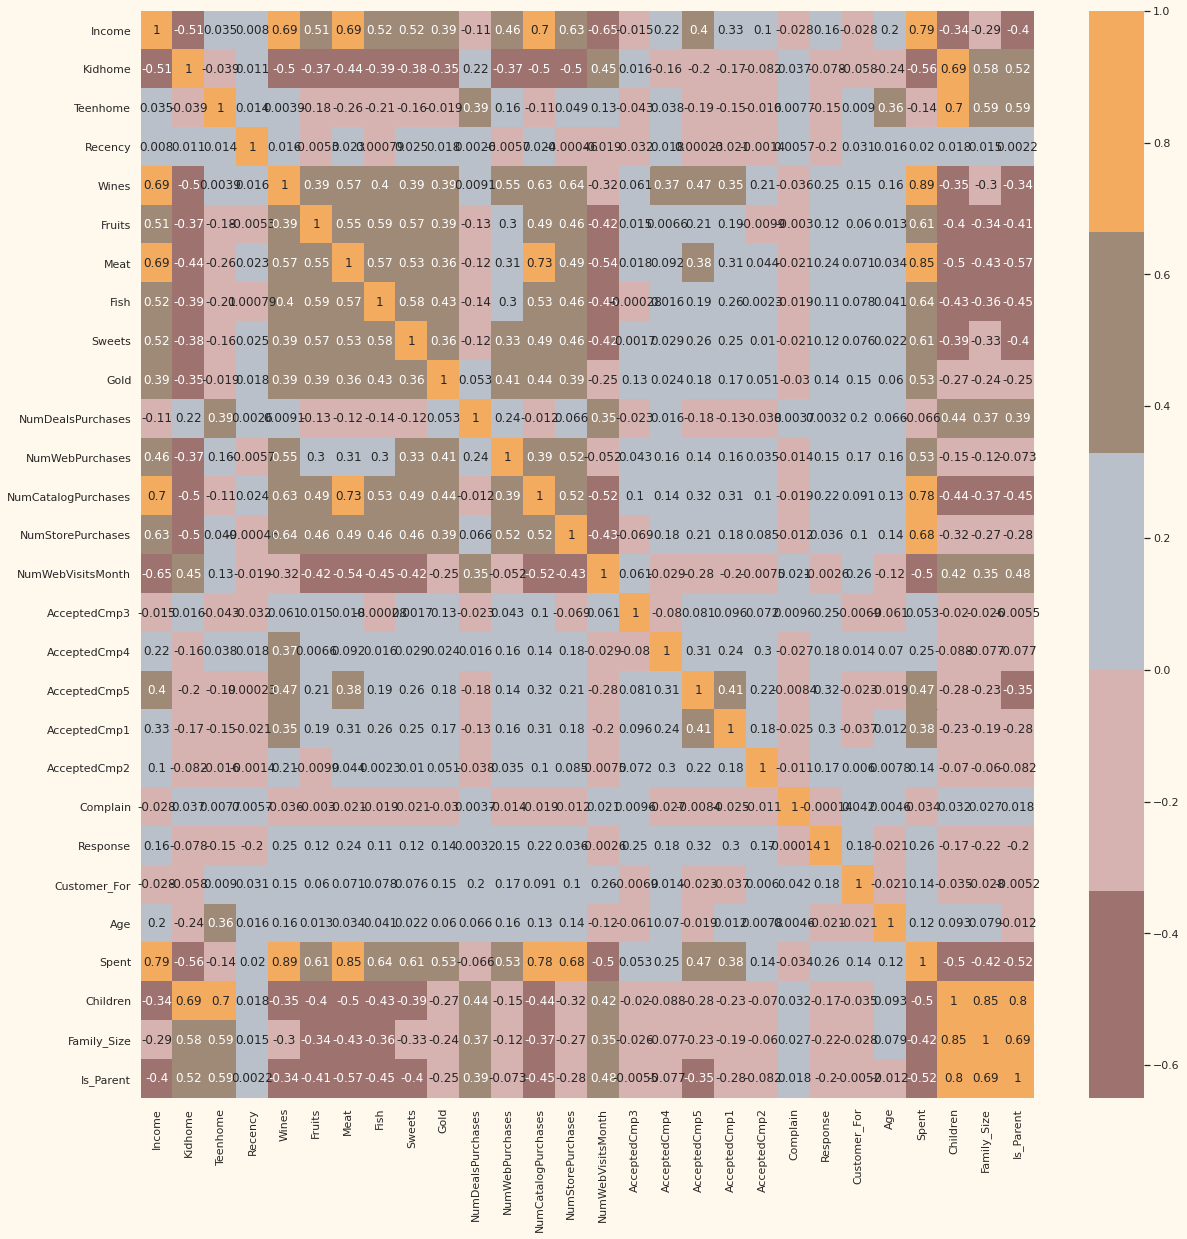

In [53]:
#correlation matrix
corrmat= X_EDA.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [54]:
#Get list of categorical variables
s = (X_EDA.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


## Dimensionality reduction

### PCA
- Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

In [58]:
n_components = 3 # reduce to this dimensions
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(X_EDA)
PCA_ds = pd.DataFrame(pca.transform(X_EDA), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.429437e-16,2.878377,-5.969395,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-9.435892e-18,1.706839,-4.312184,-1.328304,-0.158030,1.242265,6.142645
col3,2212.0,7.260116e-17,1.221956,-3.530763,-0.828709,-0.022538,0.799510,6.615153


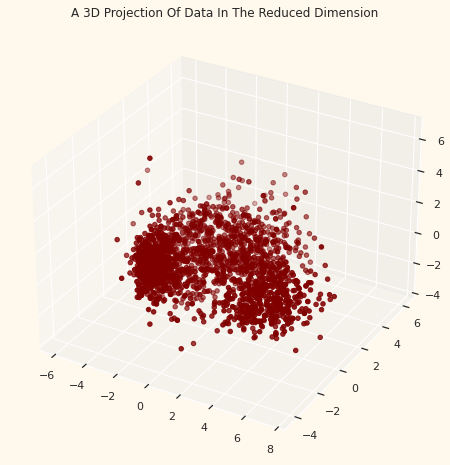

In [59]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Insights
- There in't much missing data, we can drop safely the rows with any missing.
- Exist critical outliers, specially in +Age and income


<a id="5"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">MODELING</p>

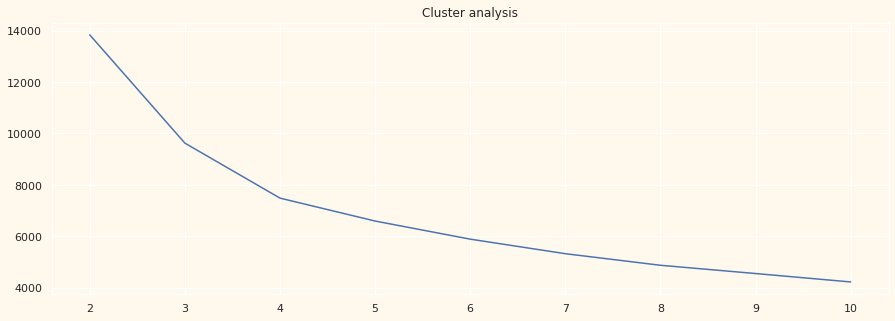

In [74]:
distorsions = []

grid_clusters = [i for i in range(2,11)]
for k in grid_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(grid_clusters, distorsions)
plt.grid(True)
plt.title('Cluster analysis')
plt.show()


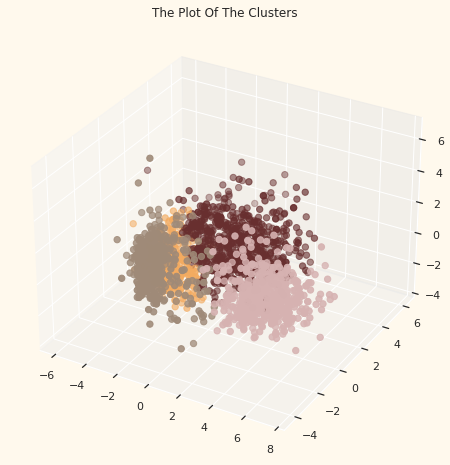

In [75]:
x =X_train["col1"]
y =X_train["col2"]
z =X_train["col3"]
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(X_train)
X_clean["Clusters"] = yhat_AC

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=X_clean["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

<a id="6"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATION</p>

<a id="7"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DISCUSSION</p>

## Patterns study

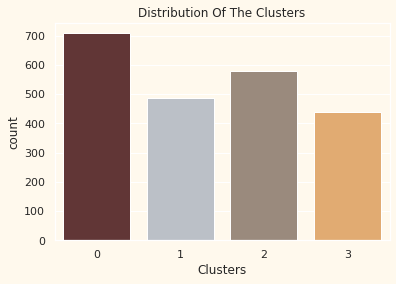

In [76]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=X_clean["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

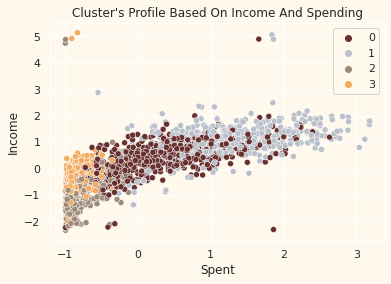

In [77]:
pl = sns.scatterplot(data = X_clean,x=X_clean["Spent"], y=X_clean["Income"],hue=X_clean["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

## Clusters distributions
- detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

In [80]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

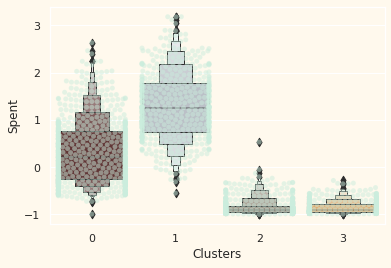

In [81]:

plt.figure()
pl=sns.swarmplot(x=X_clean["Clusters"], y=X_clean["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=X_clean["Clusters"], y=X_clean["Spent"], palette=pal)
plt.show()

<Figure size 432x288 with 0 Axes>

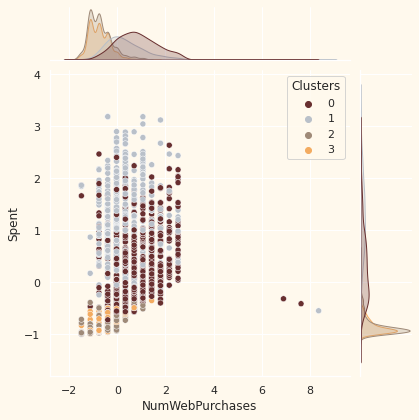

<Figure size 432x288 with 0 Axes>

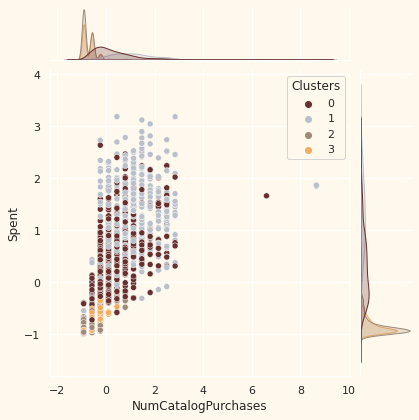

<Figure size 432x288 with 0 Axes>

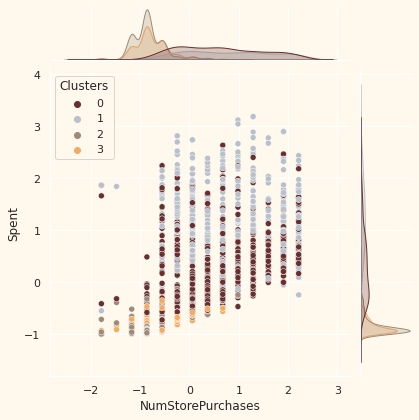

<Figure size 432x288 with 0 Axes>

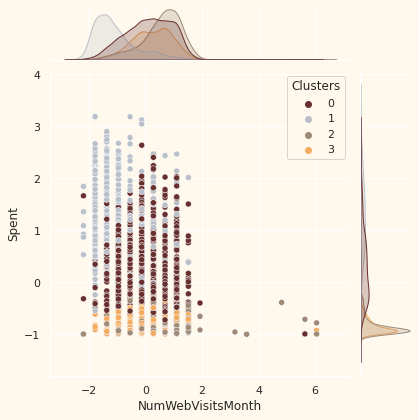

In [83]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=X_clean[i],y = X_clean["Spent"],hue=X_clean["Clusters"], palette= pal)
    plt.show()

## Profiling

<Figure size 432x288 with 0 Axes>

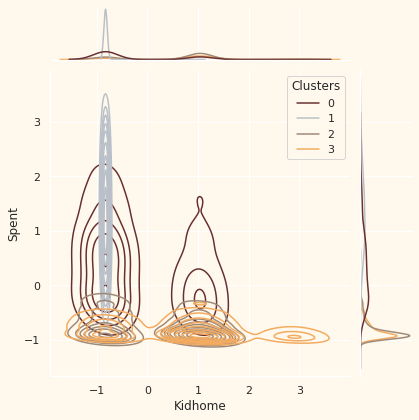

<Figure size 432x288 with 0 Axes>

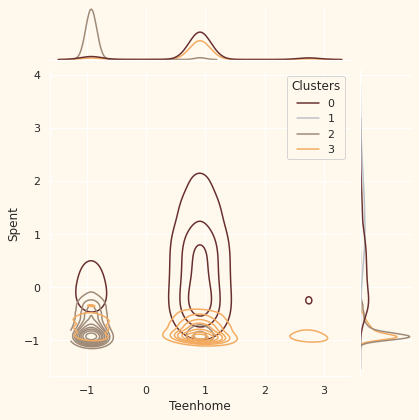

<Figure size 432x288 with 0 Axes>

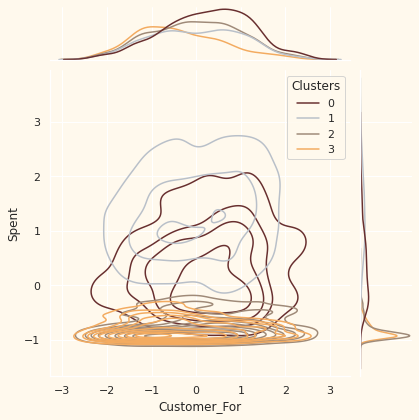

<Figure size 432x288 with 0 Axes>

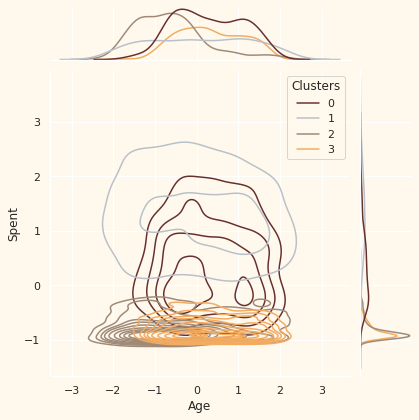

<Figure size 432x288 with 0 Axes>

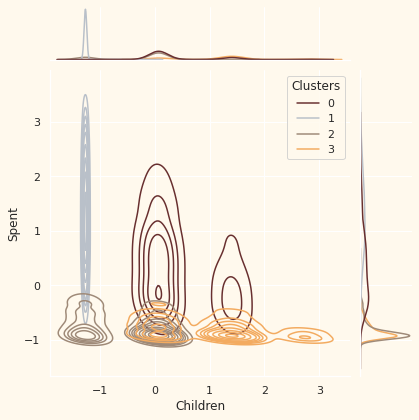

<Figure size 432x288 with 0 Axes>

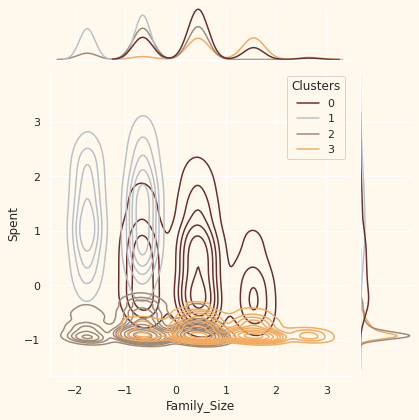

<Figure size 432x288 with 0 Axes>

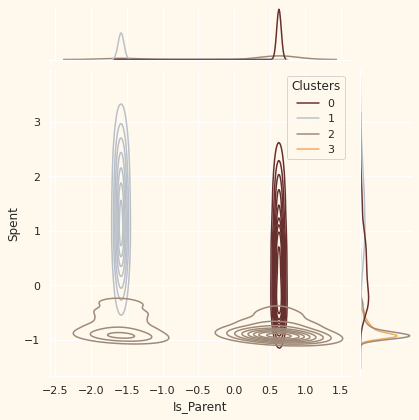

<Figure size 432x288 with 0 Axes>

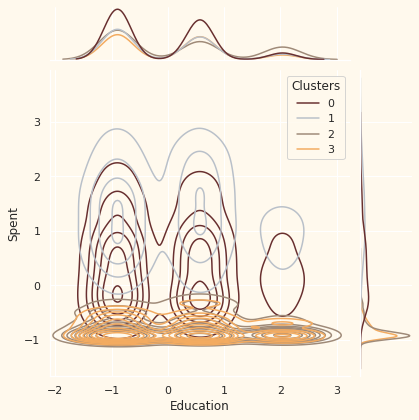

<Figure size 432x288 with 0 Axes>

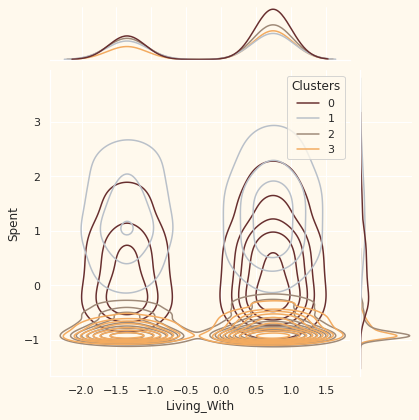

In [84]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=X_clean[i], y=X_clean["Spent"], hue =X_clean["Clusters"], kind="kde", palette=pal)
    plt.show()


## Conclusions
- The clusters seem to be fairly distributed.
### Group 0:
- Are a parent.
- At the max have 4 members in the family and at least 2.
- Single parents are a subset of this group.
- Most have a teenager at home.
- Relatively older
### Group 1:
- Are definitely not a parent.
- At the max are only 2 members in the family.
- A slight majority of couples over single people.
- Span all ages.
- A high income group.
### Group 2:
- The majority of these people are parents.
- At the max are 3 members in the family.
- They majority have one kid (and not teenagers, typically)
- Relatively younger.
### Group3:
- They are definetely a parent.
- At the max are 5 members in the family and at least 2.
- Majority of them have a teenager at home.
- Relatively older.
- A lower-income group.

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DEPLOYMENT AND ENSEMBLES</p>

<a id="9"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>

[Return to table of contents](#top)